# Reducing hospital readmissions

## 📖 Background
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

## 💾 The data
You have access to ten years of patient information ([source](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)):

#### Information in the file
- "age" - age bracket of the patient
- "time_in_hospital" - days (from 1 to 14)
- "n_procedures" - number of procedures performed during the hospital stay
- "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
- "n_medications" - number of medications administered during the hospital stay
- "n_outpatient" - number of outpatient visits in the year before a hospital stay
- "n_inpatient" - number of inpatient visits in the year before the hospital stay
- "n_emergency" - number of visits to the emergency room in the year before the hospital stay
- "medical_specialty" - the specialty of the admitting physician
- "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
- "diag_2" - secondary diagnosis
- "diag_3" - additional secondary diagnosis
- "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
- "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
- "change" - whether there was a change in the diabetes medication ('yes' or 'no')
- "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
- "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no') 

***Acknowledgments**: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records," BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.*

In [140]:
# import the necessary modules for analysis
import pandas as pd
import numpy as np
import scipy
from scipy.stats import pearsonr
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score

# import the necessary modules for visualization
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
%matplotlib inline

# load the data
df = pd.read_csv('data/hospital_readmissions.csv')

## 💪 Competition challenge
Create a report that covers the following:

1. What is the most common primary diagnosis by age group? 
2. Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates. 
3. On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## Summary of Findings

The analysis shows a weak correlation between the inpatient visits and being readmitted r(24999) = 0.2,p < .001. The correlation is weak, Still, it seems that the higher the number of inpatient visits the past year, there's a slightly higher chance of being readmitted. The number of outpatient visits showed some correlation with readmission as well, but weaker r(24999) = 0.1,p < .001.

So, the number inpatient and outpatient visits could potentially hint at the chances of readmission for patients. The higher the numbers, the higher the chances.

## ⌛️ Time is ticking. Good luck!

## All necessary functions are here

In [2]:
def make_clusters(data):
    # X = data.drop(columns = ["readmitted"]).values
    # y = data["readmitted"].values
    X = data.values
    wss = []
    for i in range(1, 4):
        kmeans = KMeans(n_clusters=i, random_state=21)
        kmeans.fit(X)
        wss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, 4), wss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Within-Cluster Sum of Squares (WSS)')
    plt.title('Elbow Curve')
    plt.show()

In [3]:
def apply_Ridge(X, y):

    # Split data into training, validation, and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=21)
    
    ridge = Ridge()
    # Train the model on the training set
    ridge.fit(X_train, y_train)
    
    # Use cross-validation to evaluate the model
    scores = cross_val_score(ridge, X_val, y_val, cv=5)

    # Evaluate the model on the testing set
    score = ridge.score(X_test, y_test)

    # Print the R^2 score
    print("R^2 score:", score)
    # Print the mean and standard deviation of the scores
    print("Cross-validation scores:", scores)
    print("Mean score:", scores.mean())
    print("Standard deviation:", scores.std())
    
    # Make predictions on the test data
    y_pred = ridge.predict(X_test)

    # Plot the predicted values versus the actual values
    plt.scatter(X_test, y_test)
    plt.scatter(X_test, np.round(y_pred),c=y_test, cmap='bwr')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Ridge Regression Results")
    plt.show()

In [4]:
def choose_alpha_for_ridge(X, y):
    # Create array of alpha values to try
    alphas = np.logspace(-4, 4, 9)

    # Iterate over alpha values and evaluate model using cross-validation
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        scores = cross_val_score(ridge, X, y, cv=5)
        print("alpha =", alpha)
        print("Cross-validation scores:", scores)
        print("Mean score:", scores.mean())
        print("Standard deviation:", scores.std())

In [85]:
def make_PCA_clusters(data):
    # X = data.drop(columns = ["readmitted"]).values
    X = data.values
    # PCA with 2 components
    pca = PCA(n_components = 2)
    
    # fit the model to the data and transform the data
    pca.fit(X)
    X_PCA = pca.transform(X)
    
    # do k-nearest neighbors clustering & fit to data
    kmeans = KMeans(n_clusters = 2, random_state = 21)
    kmeans.fit(X_PCA)
    labels = kmeans.labels_
    
    # color each cluster based on the labels
    plt.scatter(X_PCA[:,0], X_PCA[:,1], c = labels)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
     

In [83]:
def do_PCA(data,plot_or_not):
    # X = data.drop(columns = ["readmitted"]).values
    X = data.values
    # PCA with 2 components
    pca = PCA(n_components = 2)
    
    # fit the model to the data and transform the data
    pca.fit(X)
    
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    
    X_PCA = pca.transform(X)
    
    # Plot the PCA results
    if plot_or_not == 1:    
        pca = PCA(n_components = 2)

    X_df = pd.DataFrame(data = X_PCA
                 , columns = ['principal component 1', 'principal component 2'])
    plt.figure()

    plt.scatter(X_df.loc[~df_clean['readmitted'], 'principal component 1']
               , X_df.loc[~df_clean['readmitted'], 'principal component 2'], c = 'c', s = 50)

    plt.scatter(X_df.loc[df_clean['readmitted'], 'principal component 1']
               , X_df.loc[df_clean['readmitted'], 'principal component 2'], c = 'm', s = 50)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Results")
    plt.show()



In [38]:
# create a plot with bar subplots to examine the distribution
# in each column
def create_bar_plot(df, plt_nrows,plt_ncolumns):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=plt_nrows, ncols=plt_ncolumns, figsize=(12,8))
     
    # Iterate over columns in df and create a bar plot in the corresponding subplot
    for i, col in enumerate(df.columns):
        # Get the appropriate subplot
        ax = axes[int(i/plt_ncolumns), i%plt_ncolumns] 
        
        # Create a bar plot in the subplot
        df[col].value_counts().plot(kind='bar', ax=ax, rot=45) 
        # Set the title of the subplot to the column name
        ax.set_title(col) 

    # Add some space between the subplots so they don't block labels
    plt.subplots_adjust(wspace=0.3, hspace=1.8)

    # Display the plot
    plt.show()
    

In [36]:
# create a plot with histogram subplots to examine the distribution
# in each column
def create_hist_plot(df, plt_nrows,plt_ncolumns):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=plt_nrows, ncols=plt_ncolumns, figsize=(12,6))
     
    # Iterate over columns in df and create a histogram in the corresponding subplot
    for i, col in enumerate(df.columns):
        ax = axes[int(i/plt_ncolumns), i%plt_ncolumns] 
        
        # Create a histogram plot in the subplot
        df[col].plot(kind='hist', ax=ax, rot=45) 
        # Set the title of the subplot to the column name
        ax.set_title(col) 

    # Add space between the subplots so they don't block labels
    plt.subplots_adjust(wspace=0.3, hspace=1.2)

    # Display the plot
    plt.show()

In [129]:
# create a plot with histogram subplots to examine the distribution
# in each column
def contingency_tab_plot(df, plt_nrows,plt_ncolumns):
    readmitted = df['readmitted']
    df = df.drop(columns = ["readmitted"])
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=plt_nrows, ncols=plt_ncolumns, figsize=(12,6))
     
    # Iterate over columns in df and create a histogram in the corresponding subplot
    for i, col in enumerate(df.columns):
        contingency_table = pd.crosstab(readmitted, df[col])
        ax = axes[int(i/plt_ncolumns), i%plt_ncolumns] 
        # Plot the contingency table as a stacked bar chart
        contingency_table.plot(kind='bar', stacked=True)
        # Set the title of the subplot to the column name
        ax.set_title(col) 

    # Add space between the subplots so they don't block labels
    plt.subplots_adjust(wspace=0.3, hspace=1.2)

    # Display the plot
    plt.show()

In [7]:
# function takes dataframe and a list of column names where
# row entries are yes/no
# as input, returns the dataframe with updated columns
# that are saved as boolean type
def convert2binary(df, column_name_list):
    
    for column_name in column_name_list:
        df_bin = pd.get_dummies(df[column_name])

        # yes = 1 and no = 0, so drop the no column
        df_bin = df_bin.drop(["no"], axis=1)

        # create a new data frame with the addition of the binary column
        df_appended = pd.concat((df, df_bin), axis=1)

        # remove the old column with yes/no 
        df_appended = df_appended.drop([column_name], axis=1)

        # correct the name for the column_name column 
        df = df_appended.rename(columns={"yes": column_name})
        
        # and set the data type as boolean
        df[column_name] = df[column_name].astype("bool")
        
    return(df)

# function takes in dataframe and a list of column names 
# as input and returns the updated dataframe with columns
# in column names stored as categorical

def convert2category(df, column_name_list):
    
    # iterate over the list of columns
    for column_name in column_name_list:
        
        # set the data type as categorical
        df[column_name] = df[column_name].astype("category")
        
    return(df)

## Cleaning the Data

Before doing any analysis, let's make sure the data is ready by addressing the following:
1. Are there duplicate and thus redundant entries?
2. Is anything misspelled? (e.g. Mising instead of Missing)
3. Any NA values? How many? How to deal with them?

First, let's take a look at the shape and type of data:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

We see that there are no NA entries although some entries are 'Missing.' First, remove duplicate entries from the dataframe:

In [9]:
df_clean = df.drop_duplicates()

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

The size stayed the same. This shows that we did not have any duplicates to start with! Now, many of the categorical columns are saved as 'object'. Let's fix that by converting them to categorical or binary (yes/no). 

In [11]:
df_clean.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


We apply the two functions above to the boolean columns and the categorical columns:

In [12]:
df_clean = convert2binary(df, ["readmitted","change", "diabetes_med"])

df_clean = convert2category(df_clean, ['age',
                            'medical_specialty', 'diag_1', 'diag_2', 'diag_3'])

Some columns seem to have 'Missing' data, let's see which ones:

In [24]:
for column_name in df_clean.columns:
    print(df_clean[column_name].isin(["Missing"]).unique())

[False]
[False]
[False]
[False]
[False]
[False]
[False]
[False]
[ True False]
[False  True]
[False  True]
[False  True]
[False]
[False]
[False]
[False]
[False]


Columns 8-11 have 'Missing' data.

Now, let's take a look at the levels for the two test columns.

In [12]:
df['A1Ctest'].unique()

array(['no', 'normal', 'high'], dtype=object)

There are definitely 2 levels here, normal and high. no indicates no tests were done, but for now, we just store it as the lowest level in the ordered categorical columns:

In [13]:
test_type = pd.api.types.CategoricalDtype(categories=['no', 'normal','high'], ordered=True)

df_clean["glucose_test"] = df["glucose_test"].astype(test_type)
df_clean["A1Ctest"] = df["A1Ctest"].astype(test_type)

In [16]:
df_clean.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,readmitted,change,diabetes_med
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,False,False,True
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,False,False,True
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,True,True,True
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,True,True,True
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,False,False,True


<AxesSubplot: >

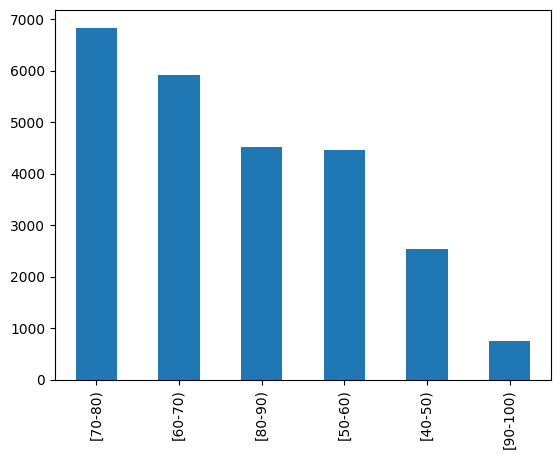

In [22]:
# checking for consistency in the age column & also looking at the distribution
df['age'].value_counts().plot(kind = 'bar')

<AxesSubplot: >

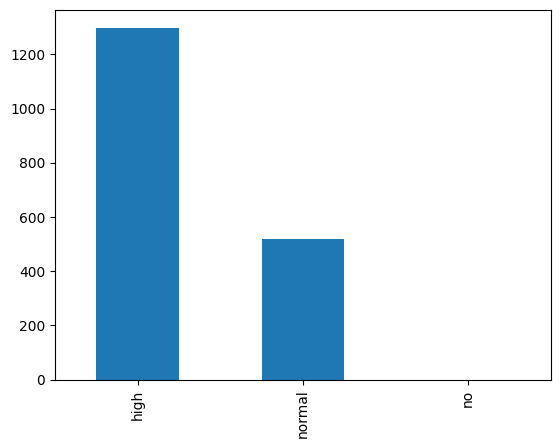

In [47]:
# df_clean.groupby(by='readmitted')['age'].value_counts().plot(kind = 'bar')
df_clean_A1Ctest = df_clean[df_clean['A1Ctest'] != 'no']
df_clean_A1Ctest.set_index('A1Ctest')
df_clean_A1Ctest[df_clean_A1Ctest['readmitted']]['A1Ctest'].value_counts().plot(kind = 'bar')



In [54]:
df_clean['age'] = df_clean['age'].str[1:3].astype("int64")

## Analysis of Each Metric

First, we want to get to know the data & develop some intuition for it. we'll gain some insight into the general distribution of the data, and then, we'll take a closer look by visualizing it:

In [23]:
df_clean.describe()

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency
count,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600
std,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873
min,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000
max,14.00000,113.00000,6.000000,79.000000,33.000000,15.000000,64.000000


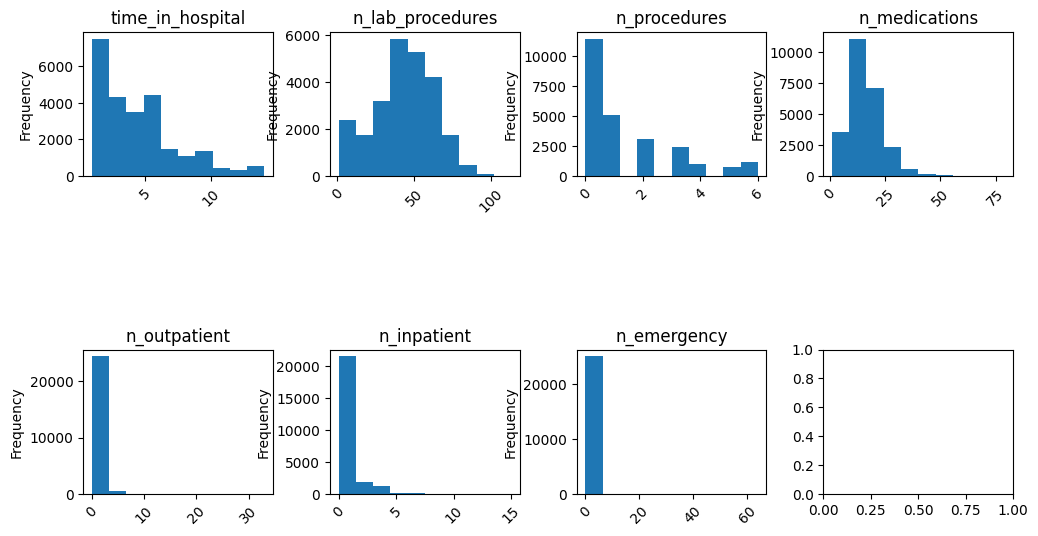

In [40]:
create_hist_plot(df_clean.iloc[:,1:8], 2,4)

The n_emergency plot & summary table show that the majority of patients had very few visits to the emergency room (ER) in the year before the hospital stay. More precisely,

In [69]:
print('percentage of patients with ER visits the prior year:',   np.sum(df_clean['n_emergency'] > 0 )/25000*100)
print('percentage of patients with more than 2 ER visits the prior year:',   np.sum(df_clean['n_emergency'] > 2 )/25000*100)

print('percentage of patients with more than 2 outpatient visits the prior year:',   np.sum(df_clean['n_inpatient'] > 2 )/25000*100)
print('percentage of patients with more than 2 inpatient visits the prior year:',   np.sum(df_clean['n_outpatient'] > 2 )/25000*100)

percentage of patients with ER visits the prior year: 10.911999999999999
percentage of patients with more than 2 ER visits the prior year: 1.444
percentage of patients with more than 2 outpatient visits the prior year: 6.512
percentage of patients with more than 2 inpatient visits the prior year: 4.6080000000000005


only 10.9% visited the ER more the previous year and about 1% visited more than twice. So, a lot of outliers in these columns.

In [67]:
# df_clean[df_clean['n_emergency'] > 5]['age'].value_counts().plot(kind = 'bar')

Now, to get a sense of the overall distribution of data, let's create some histograms of the numerical data & bar plots of the categorical columns:

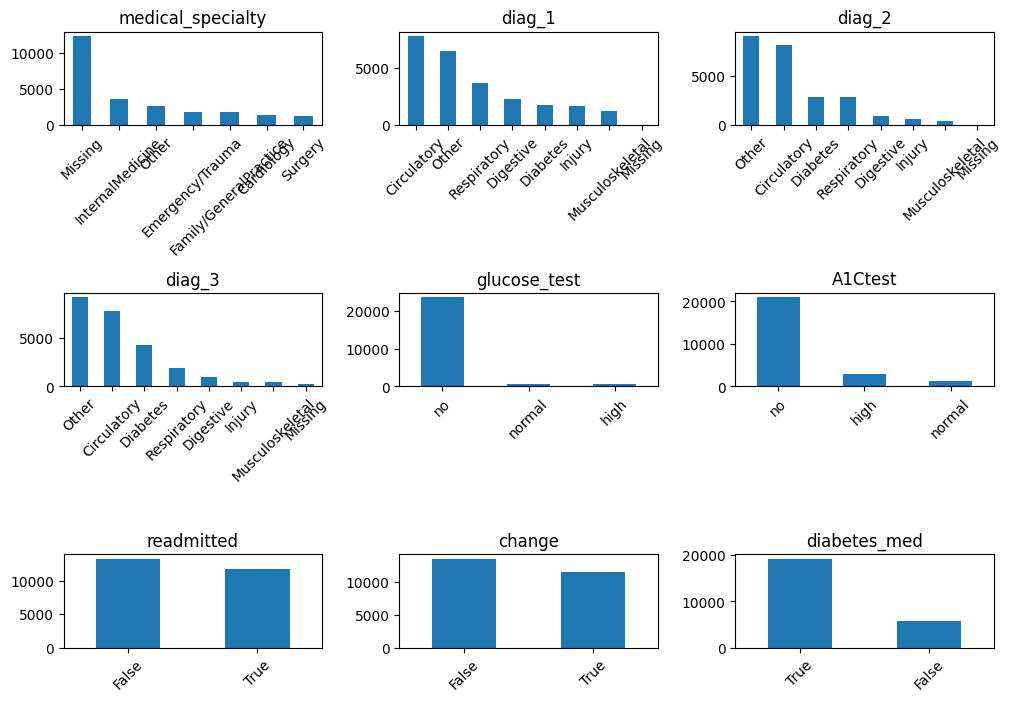

In [39]:
create_bar_plot(df_clean.iloc[:,8:17], 3,3)


It seems that there's a lot of missing data in columns medical_specialty, not particularly a column I'd expect a lot from in terms of contributing to the readmission rate. 

# Analysis of Relations Between the Metrics

We finally explore what could be correlated and perhaps causing a higher chance of being readmitted. First, taking a look at the categorical data:

In [132]:
# Perform chi-squared test of independence between medication and first diagnosis
chi2, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df_clean[df_clean["diag_1"] != "Missing"]["diag_1"] , df_clean[df_clean["diag_1"] != "Missing"]["readmitted"]))

# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", p)

# Perform chi-squared test of independence between medication and glucose test
chi2, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df_clean["glucose_test"], df_clean["readmitted"]))

# Print the results
print("Chi-squared test statistic:", chi2)
print("P-value:", p)

Chi-squared test statistic: 84.89513380512619
P-value: 3.4704584980101605e-16
Chi-squared test statistic: 7.753214987229587
P-value: 0.020721002208701197


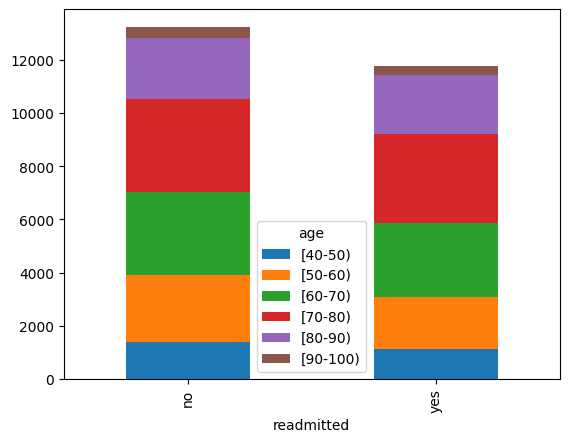

In [130]:
# Create a contingency table using the crosstab function
contingency_table = pd.crosstab(df['readmitted'], df['age'])

# Plot the contingency table as a stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.show()


Nothing jumps out so far in the categorical data for explaining the readmission rate.

Now, looking at the correlations between the numerical features:

<AxesSubplot: >

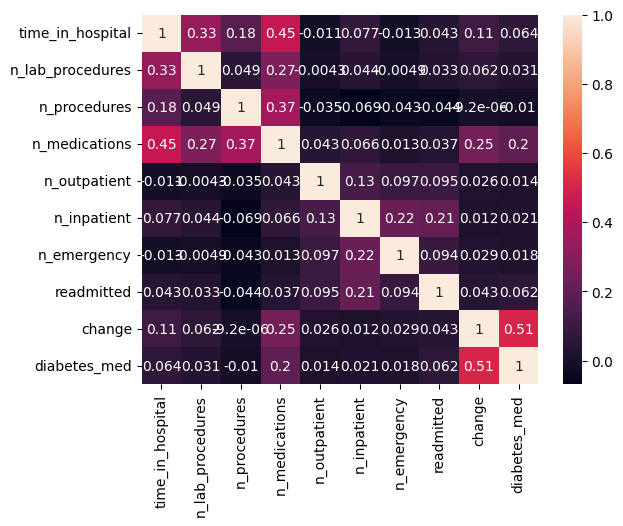

In [137]:
df_clean["readmitted"] = df_clean["readmitted"].astype("bool")
sns.heatmap(df_clean.corr(), annot = True)

Not a lot of strong correlations going on, but it's worth noting the following weak correlations, in the order of decreasing correlation magnitude:
> whether a patient takes diabetes medication & whether they stopped or started taking it in that year (which makes sense)
> time in hospital & number of medications 
> number of procedures & number of medications
> number of lab procedures & time in hospital

& other weak correlations that make sense. 

The only metric here that's correlated with readmission is the number of inpatient visits, and that's a weak correlation. Still, it seems that the higher the number of inpatient visits the past year, there's a slightly higher chance of being readmitted. The number of outpatient visits does not show the same correlation with readmission.

In [157]:
# credit goes to StackOverFlow for this type of correlation table with significance shown
corr_val = df_clean.corr()

pval = df_clean.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*corr_val.shape)

p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))

corr_val.round(2).astype(str) + p

,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,readmitted,change,diabetes_med
time_in_hospital,1.0***,0.33***,0.18***,0.45***,-0.01,0.08***,-0.01*,0.04***,0.11***,0.06***
n_lab_procedures,0.33***,1.0***,0.05***,0.27***,-0.0,0.04***,-0.0,0.03***,0.06***,0.03***
n_procedures,0.18***,0.05***,1.0***,0.37***,-0.03***,-0.07***,-0.04***,-0.04***,-0.0,-0.01
n_medications,0.45***,0.27***,0.37***,1.0***,0.04***,0.07***,0.01*,0.04***,0.25***,0.2***
n_outpatient,-0.01,-0.0,-0.03***,0.04***,1.0***,0.13***,0.1***,0.1***,0.03***,0.01*
n_inpatient,0.08***,0.04***,-0.07***,0.07***,0.13***,1.0***,0.22***,0.21***,0.01*,0.02***
n_emergency,-0.01*,-0.0,-0.04***,0.01*,0.1***,0.22***,1.0***,0.09***,0.03***,0.02**
readmitted,0.04***,0.03***,-0.04***,0.04***,0.1***,0.21***,0.09***,1.0***,0.04***,0.06***
change,0.11***,0.06***,-0.0,0.25***,0.03***,0.01*,0.03***,0.04***,1.0***,0.51***
diabetes_med,0.06***,0.03***,-0.01,0.2***,0.01*,0.02***,0.02**,0.06***,0.51***,1.0***


In [152]:
import statsmodels.api as sm
mod = sm.OLS(df_clean['readmitted'], df_clean['n_inpatient'])

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:             readmitted   R-squared (uncentered):               -9321.837
Model:                            OLS   Adj. R-squared (uncentered):          -9322.210
Method:                 Least Squares   F-statistic:                         -2.500e+04
Date:                Sun, 05 Mar 2023   Prob (F-statistic):                        1.00
Time:                        16:53:49   Log-Likelihood:                         -23143.
No. Observations:               25000   AIC:                                  4.629e+04
Df Residuals:                   24999   BIC:                                  4.630e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [153]:
(pval.loc['n_inpatient','readmitted'])
(pval.loc['n_outpatient','readmitted'])

1.0017945634320104e-51

<AxesSubplot: xlabel='n_inpatient', ylabel='readmitted'>

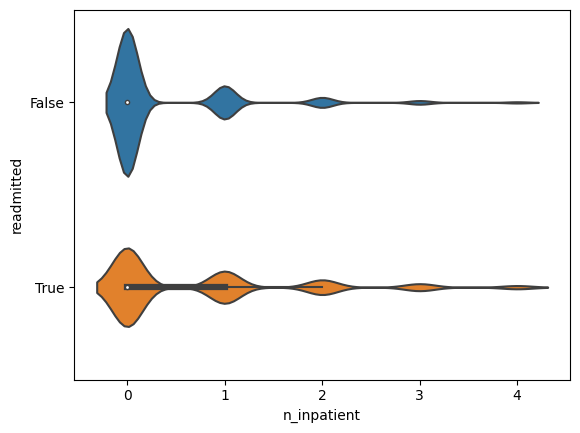

In [155]:
df_clean_np = df_clean[df_clean['n_inpatient'] < 5]
# seaborn freaks out about boolean columns sometimes
df_clean_np["readmitted"] = df_clean_np["readmitted"].astype("category")
sns.violinplot(x = 'n_inpatient', y = 'readmitted', data = df_clean_np)

R^2 score: 0.04415906221094856
Cross-validation scores: [0.02964138 0.05074919 0.04875487 0.04610152 0.02803646]
Mean score: 0.040656682656354914
Standard deviation: 0.009774377616156842


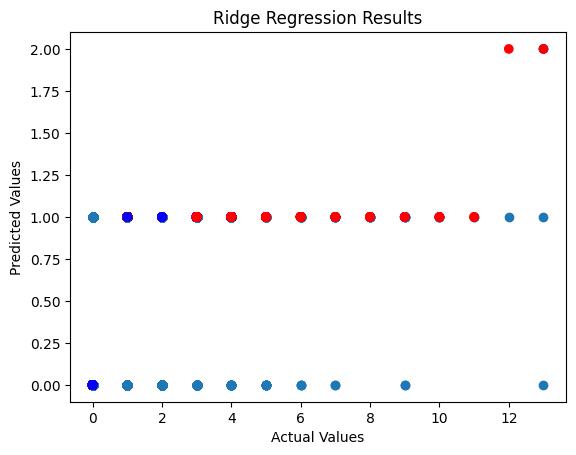

In [19]:
df_clean["readmitted"] = df_clean["readmitted"].astype("bool")
apply_Ridge(df_clean["n_inpatient"].values.reshape(-1, 1), df_clean["readmitted"].values)

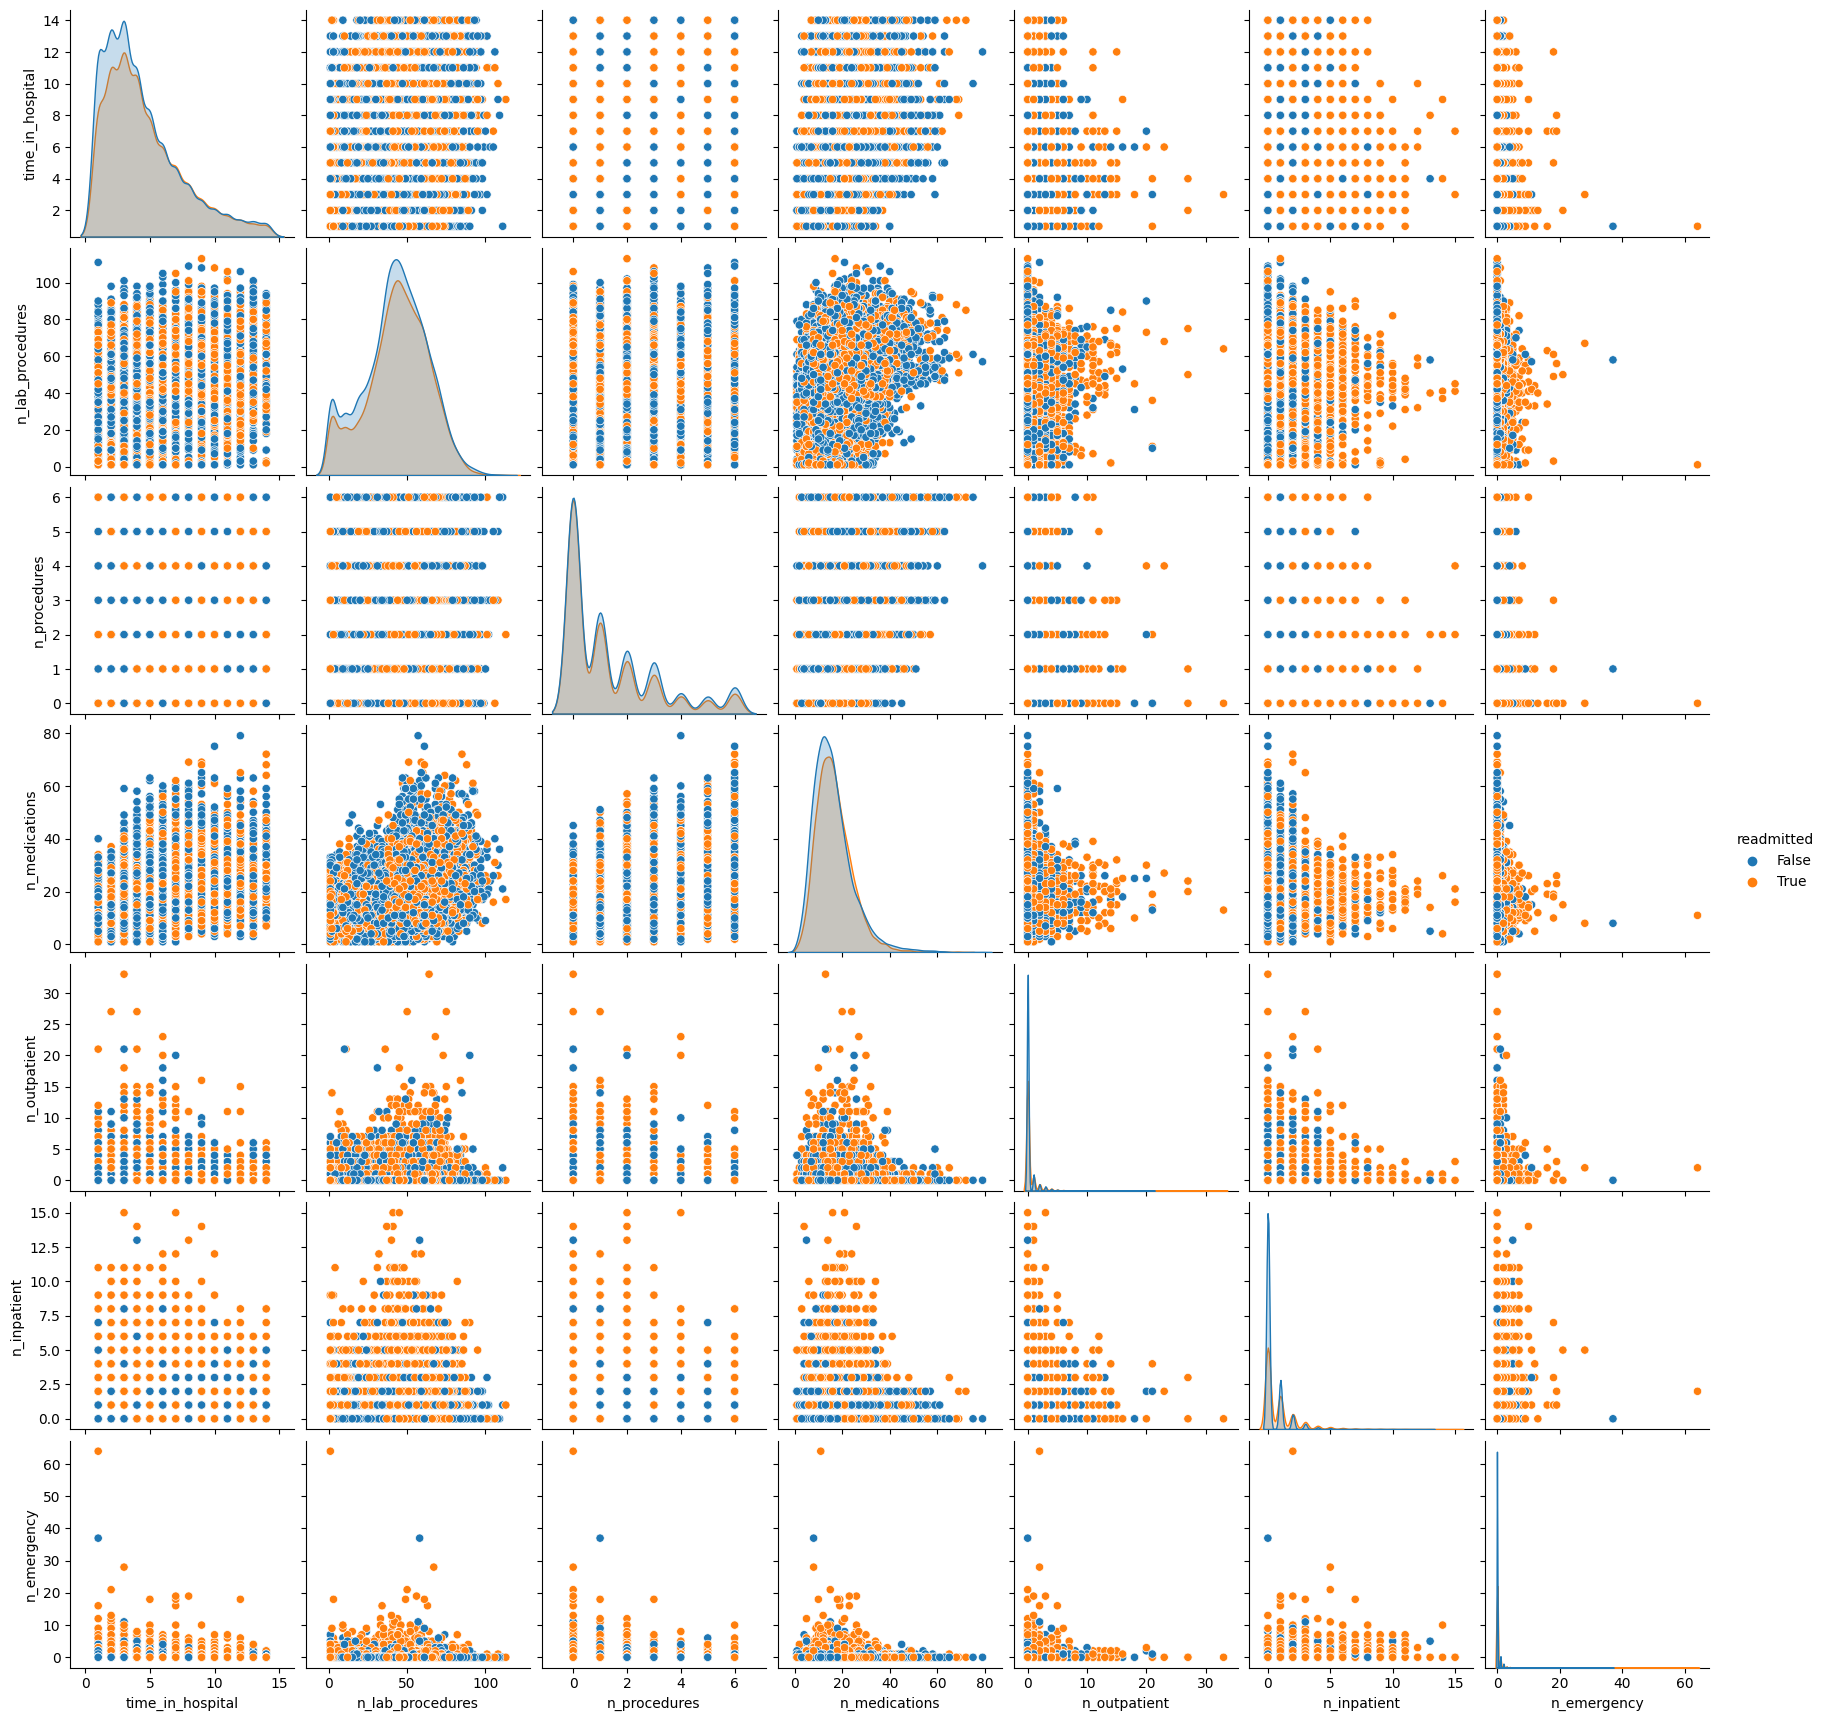

In [134]:
df_clean["readmitted"] = df_clean["readmitted"].astype("category")
sns.pairplot(df_clean, x_vars = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency'],
             y_vars = ['time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency'],
             hue = "readmitted")

A few things seem worth investigating from this plot:
curiously, the time in hospital has a bit of a higher peak for those who were not readmitted the next year, same is true for number of medications & procedures.

We also see those who were outliers in emergency visits(+40 visits), were readmitted the next year.
The number of inpatient visits seems to be higher for those readmitted the next year (also true for outpatient visits, so not really giving a distinction between the two cases).

Explained variation per principal component: [0.84417833 0.12894968]


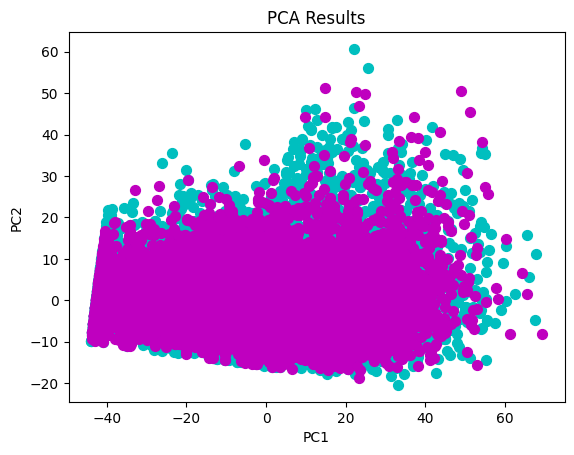

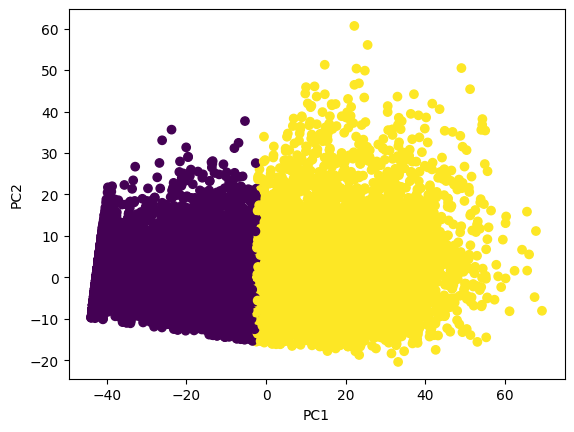

In [158]:
do_PCA(df_clean.iloc[:,1:8],1)

make_PCA_clusters(df_clean.iloc[:,1:8])

In [79]:
df_clean.columns

Index(['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures',
       'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test',
       'A1Ctest', 'readmitted', 'change', 'diabetes_med'],
      dtype='object')

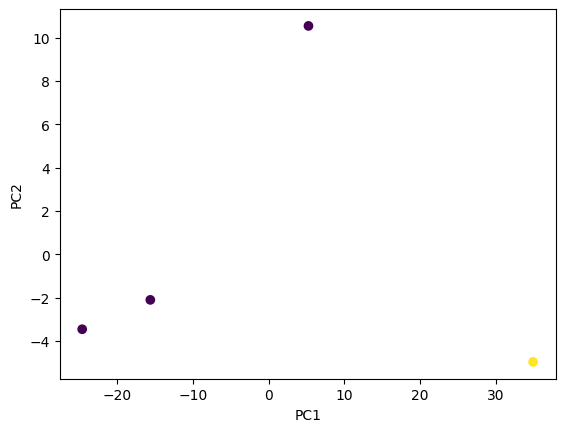

In [135]:
make_PCA_clusters(df_drop_missing.iloc[:,1:8])

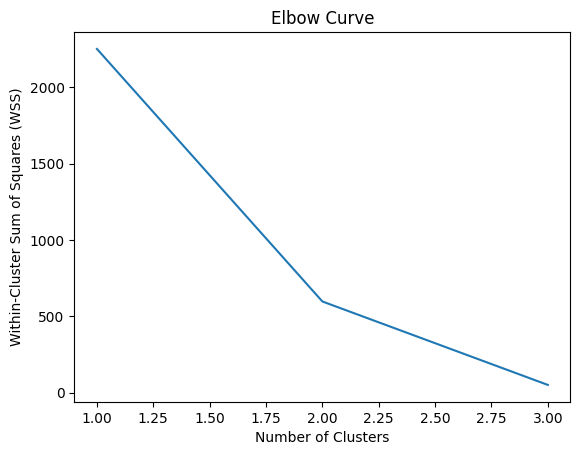

In [134]:
make_clusters(df_drop_missing.iloc[:,1:8])

In [155]:
sns.swarmplot(data=df_clean, x="n_inpatient", y="glucose_test", dodge=True)

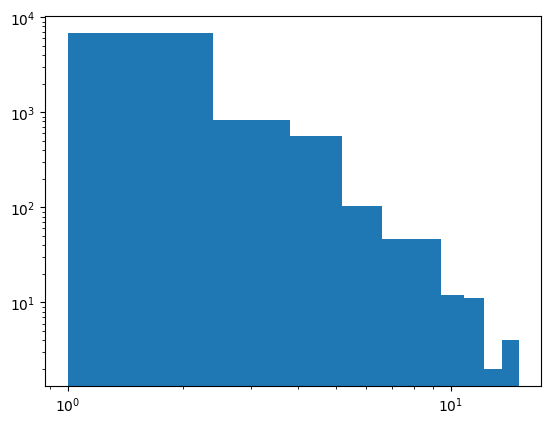

In [156]:
plt.hist(df_clean["n_inpatient"][df_clean["n_inpatient"] > 0].values)
plt.yscale("log")
plt.xscale("log")

In [159]:
df_clean["readmitted"].value_counts()

False    13246
True     11754
Name: readmitted, dtype: int64